# HW5

Name: Xulai Wu <br>
Github Username: LukeWu5121 <br>
USC ID: 6591102106

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## 1. Decision Trees as Interpretable Models

### a).

In [95]:
file_path = "../Data/diagnosis.data"
columns = [
    "Temperature", "Nausea", "LumbarPain", "UrinePushing",
    "MicturitionPain", "BurningUrethraPain", "D1", "D2"
]
df = pd.read_csv(file_path, header=None, names=columns,encoding='utf-16',sep='\t')

for col in df.columns[1:]:
    df[col] = df[col].map({'yes': 1, 'no': 0})

df["Label"] = df["D1"] * 2 + df["D2"]
print(df.head())

   Temperature  Nausea  LumbarPain  UrinePushing  MicturitionPain  \
0         35.5       0           1             0                0   
1         35.9       0           0             1                1   
2         35.9       0           1             0                0   
3         36.0       0           0             1                1   
4         36.0       0           1             0                0   

   BurningUrethraPain  D1  D2  Label  
0                   0   0   0      0  
1                   1   1   0      2  
2                   0   0   0      0  
3                   1   1   0      2  
4                   0   0   0      0  


### b).

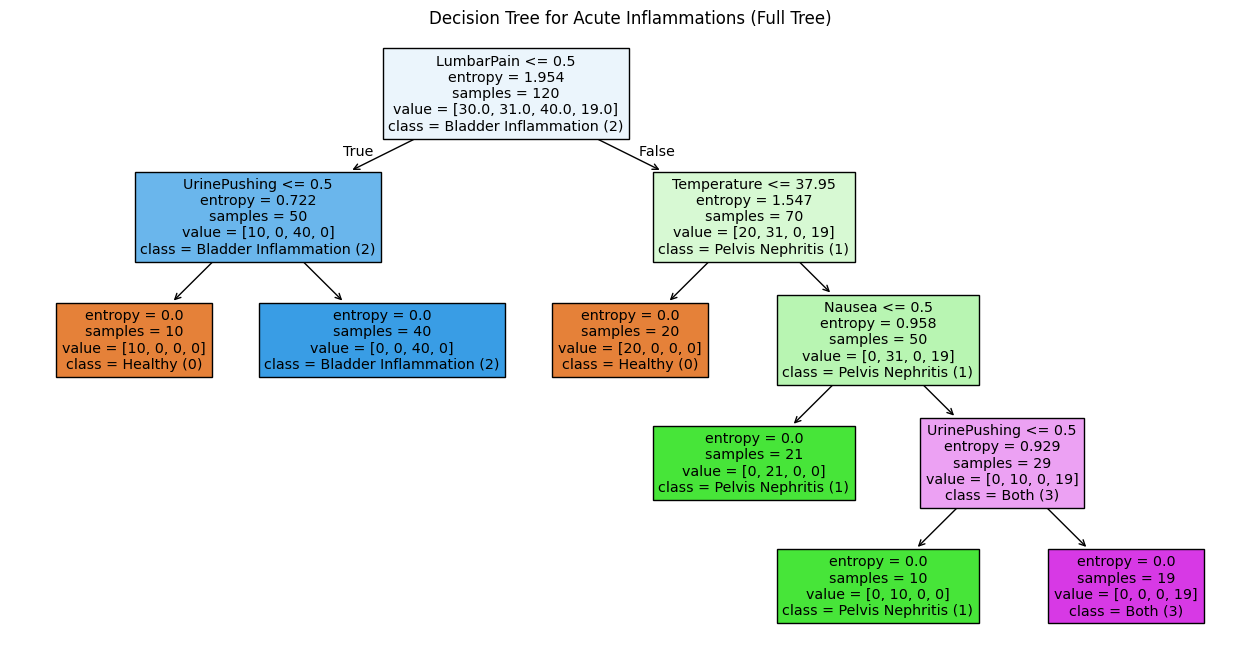

In [96]:
X = df.drop(["D1", "D2", "Label"], axis=1)
y = df["Label"]
clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=[
        "Healthy (0)",
        "Pelvis Nephritis (1)",
        "Bladder Inflammation (2)",
        "Both (3)"
    ],
    filled=True
)
plt.title("Decision Tree for Acute Inflammations (Full Tree)")
plt.show()

### c).

In [97]:
tree_rules = export_text(clf, feature_names=list(X.columns))
print(tree_rules)

|--- LumbarPain <= 0.50
|   |--- UrinePushing <= 0.50
|   |   |--- class: 0
|   |--- UrinePushing >  0.50
|   |   |--- class: 2
|--- LumbarPain >  0.50
|   |--- Temperature <= 37.95
|   |   |--- class: 0
|   |--- Temperature >  37.95
|   |   |--- Nausea <= 0.50
|   |   |   |--- class: 1
|   |   |--- Nausea >  0.50
|   |   |   |--- UrinePushing <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- UrinePushing >  0.50
|   |   |   |   |--- class: 3



### d).

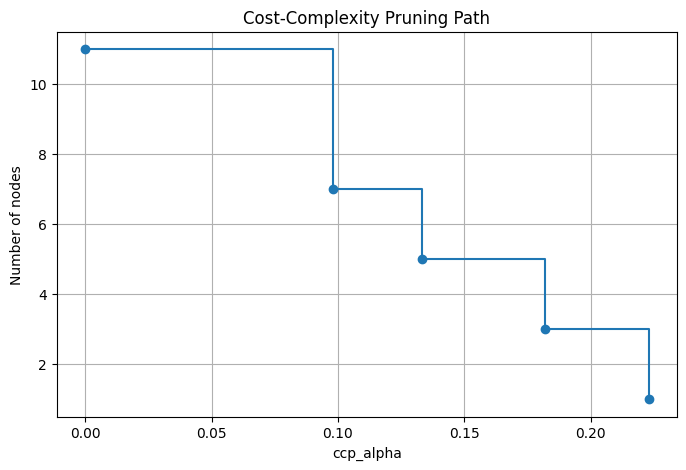

In [98]:
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
node_counts = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X, y)
    node_counts.append(clf.tree_.node_count)

plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Number of nodes")
plt.title("Cost-Complexity Pruning Path")
plt.grid(True)
plt.show()

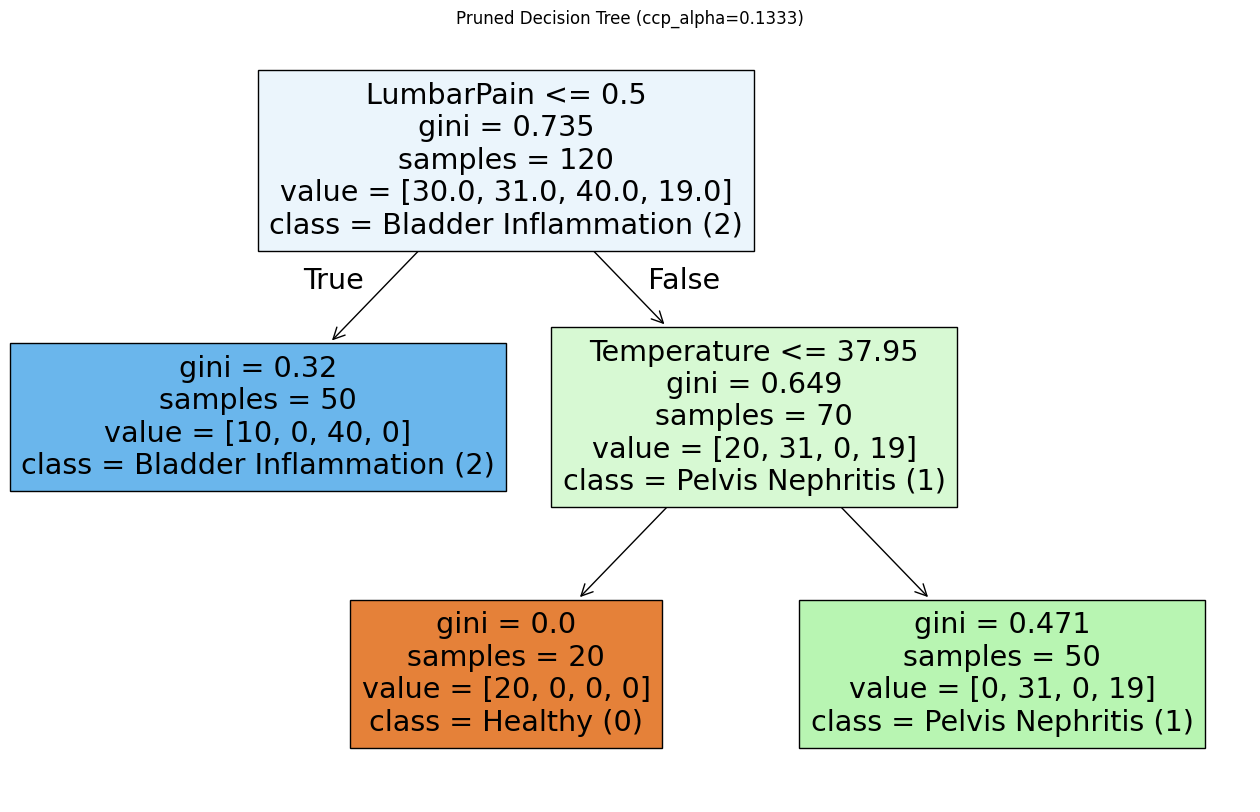

In [99]:
pick_alpha = ccp_alphas[2]  
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=pick_alpha)
pruned_tree.fit(X, y)

plt.figure(figsize=(16, 10))
plot_tree(
    pruned_tree,
    feature_names=X.columns,
    class_names=["Healthy (0)", "Pelvis Nephritis (1)", "Bladder Inflammation (2)", "Both (3)"],
    filled=True,
)
plt.title(f"Pruned Decision Tree (ccp_alpha={pick_alpha:.4f})")
plt.show()

## 2. The LASSO and Boosting for Regression

### a). b).

In [100]:
data_file = "../Data/communities.data"
names_file = "../Data/communities.names"

with open(names_file, "r") as f:
    lines = f.readlines()

columns = [
    line.split()[1]
    for line in lines
    if line.lower().startswith("@attribute")
]

df = pd.read_csv(data_file, header=None, names=columns, na_values="?")
df.isnull().sum().sort_values(ascending=False).head()
non_predictive = ['state', 'county', 'community', 'communityname', 'fold']
df = df.drop(columns=non_predictive)

#First 1495 rows are training data, the rest are test data
train_set = df.iloc[:1495].copy()
test_set = df.iloc[1495:].copy()

print(f"Original dataset shape: {df.shape}")
print(f"Train shape: {train_set.shape}")
print(f"Test shape: {test_set.shape}")

Original dataset shape: (1994, 123)
Train shape: (1495, 123)
Test shape: (499, 123)


### c).

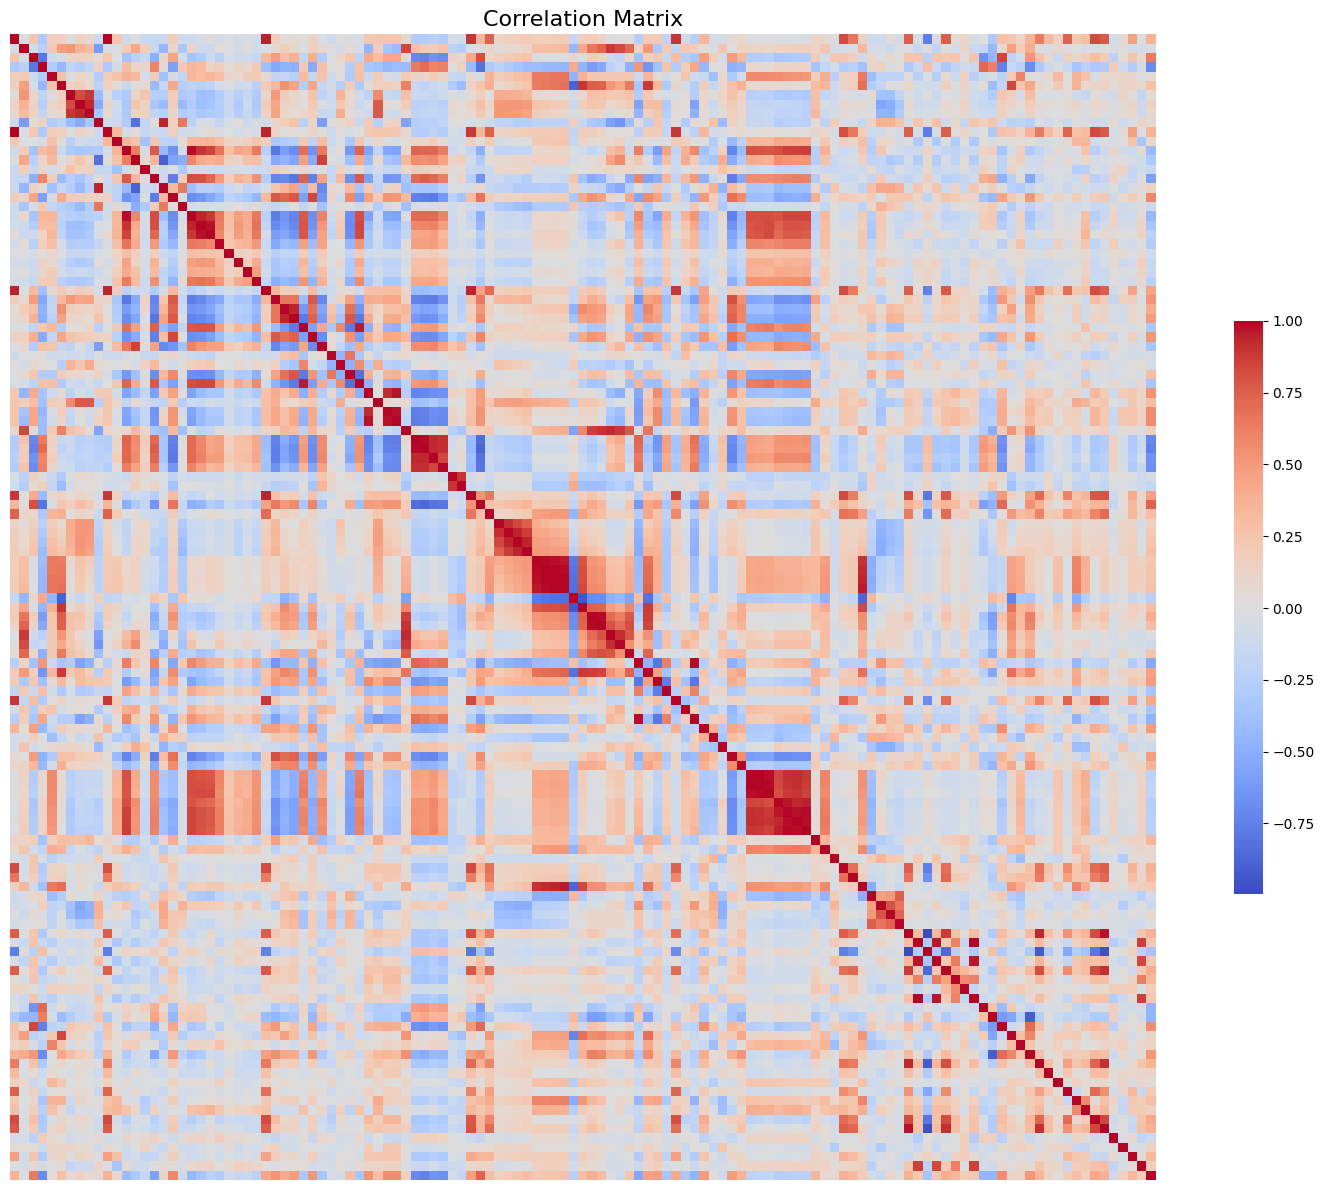

In [101]:
corr_matrix = train_set.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={'shrink': 0.5},
    xticklabels=False,
    yticklabels=False
)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

### d).

In [102]:
cv_series = (train_set.std() / train_set.mean()).sort_values(ascending=False)
print(cv_series.head(30))


NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
NumUnderPov            2.342443
population             2.241105
LemasSwornFT           2.059811
numbUrban              2.038461
PctPolicAsian          2.014256
HousVacant             1.968467
PolicOperBudg          1.862773
LemasTotalReq          1.707826
OfficAssgnDrugUnits    1.696265
LandArea               1.645408
racePctHisp            1.612091
PctPolicHisp           1.477957
PctNotSpeakEnglWell    1.456618
racepctblack           1.428885
PctUsePubTrans         1.397110
racePctAsian           1.359100
PolicCars              1.346454
PctRecentImmig         1.288287
PctRecImmig5           1.286184
PctRecImmig10          1.270476
PctRecImmig8           1.265579
PctPersDenseHous       1.132926
PctPolicBlack          1.101641
PctForeignBorn         1.065880
PctVacantBoarded       1.054827
dtype: float64


### e).

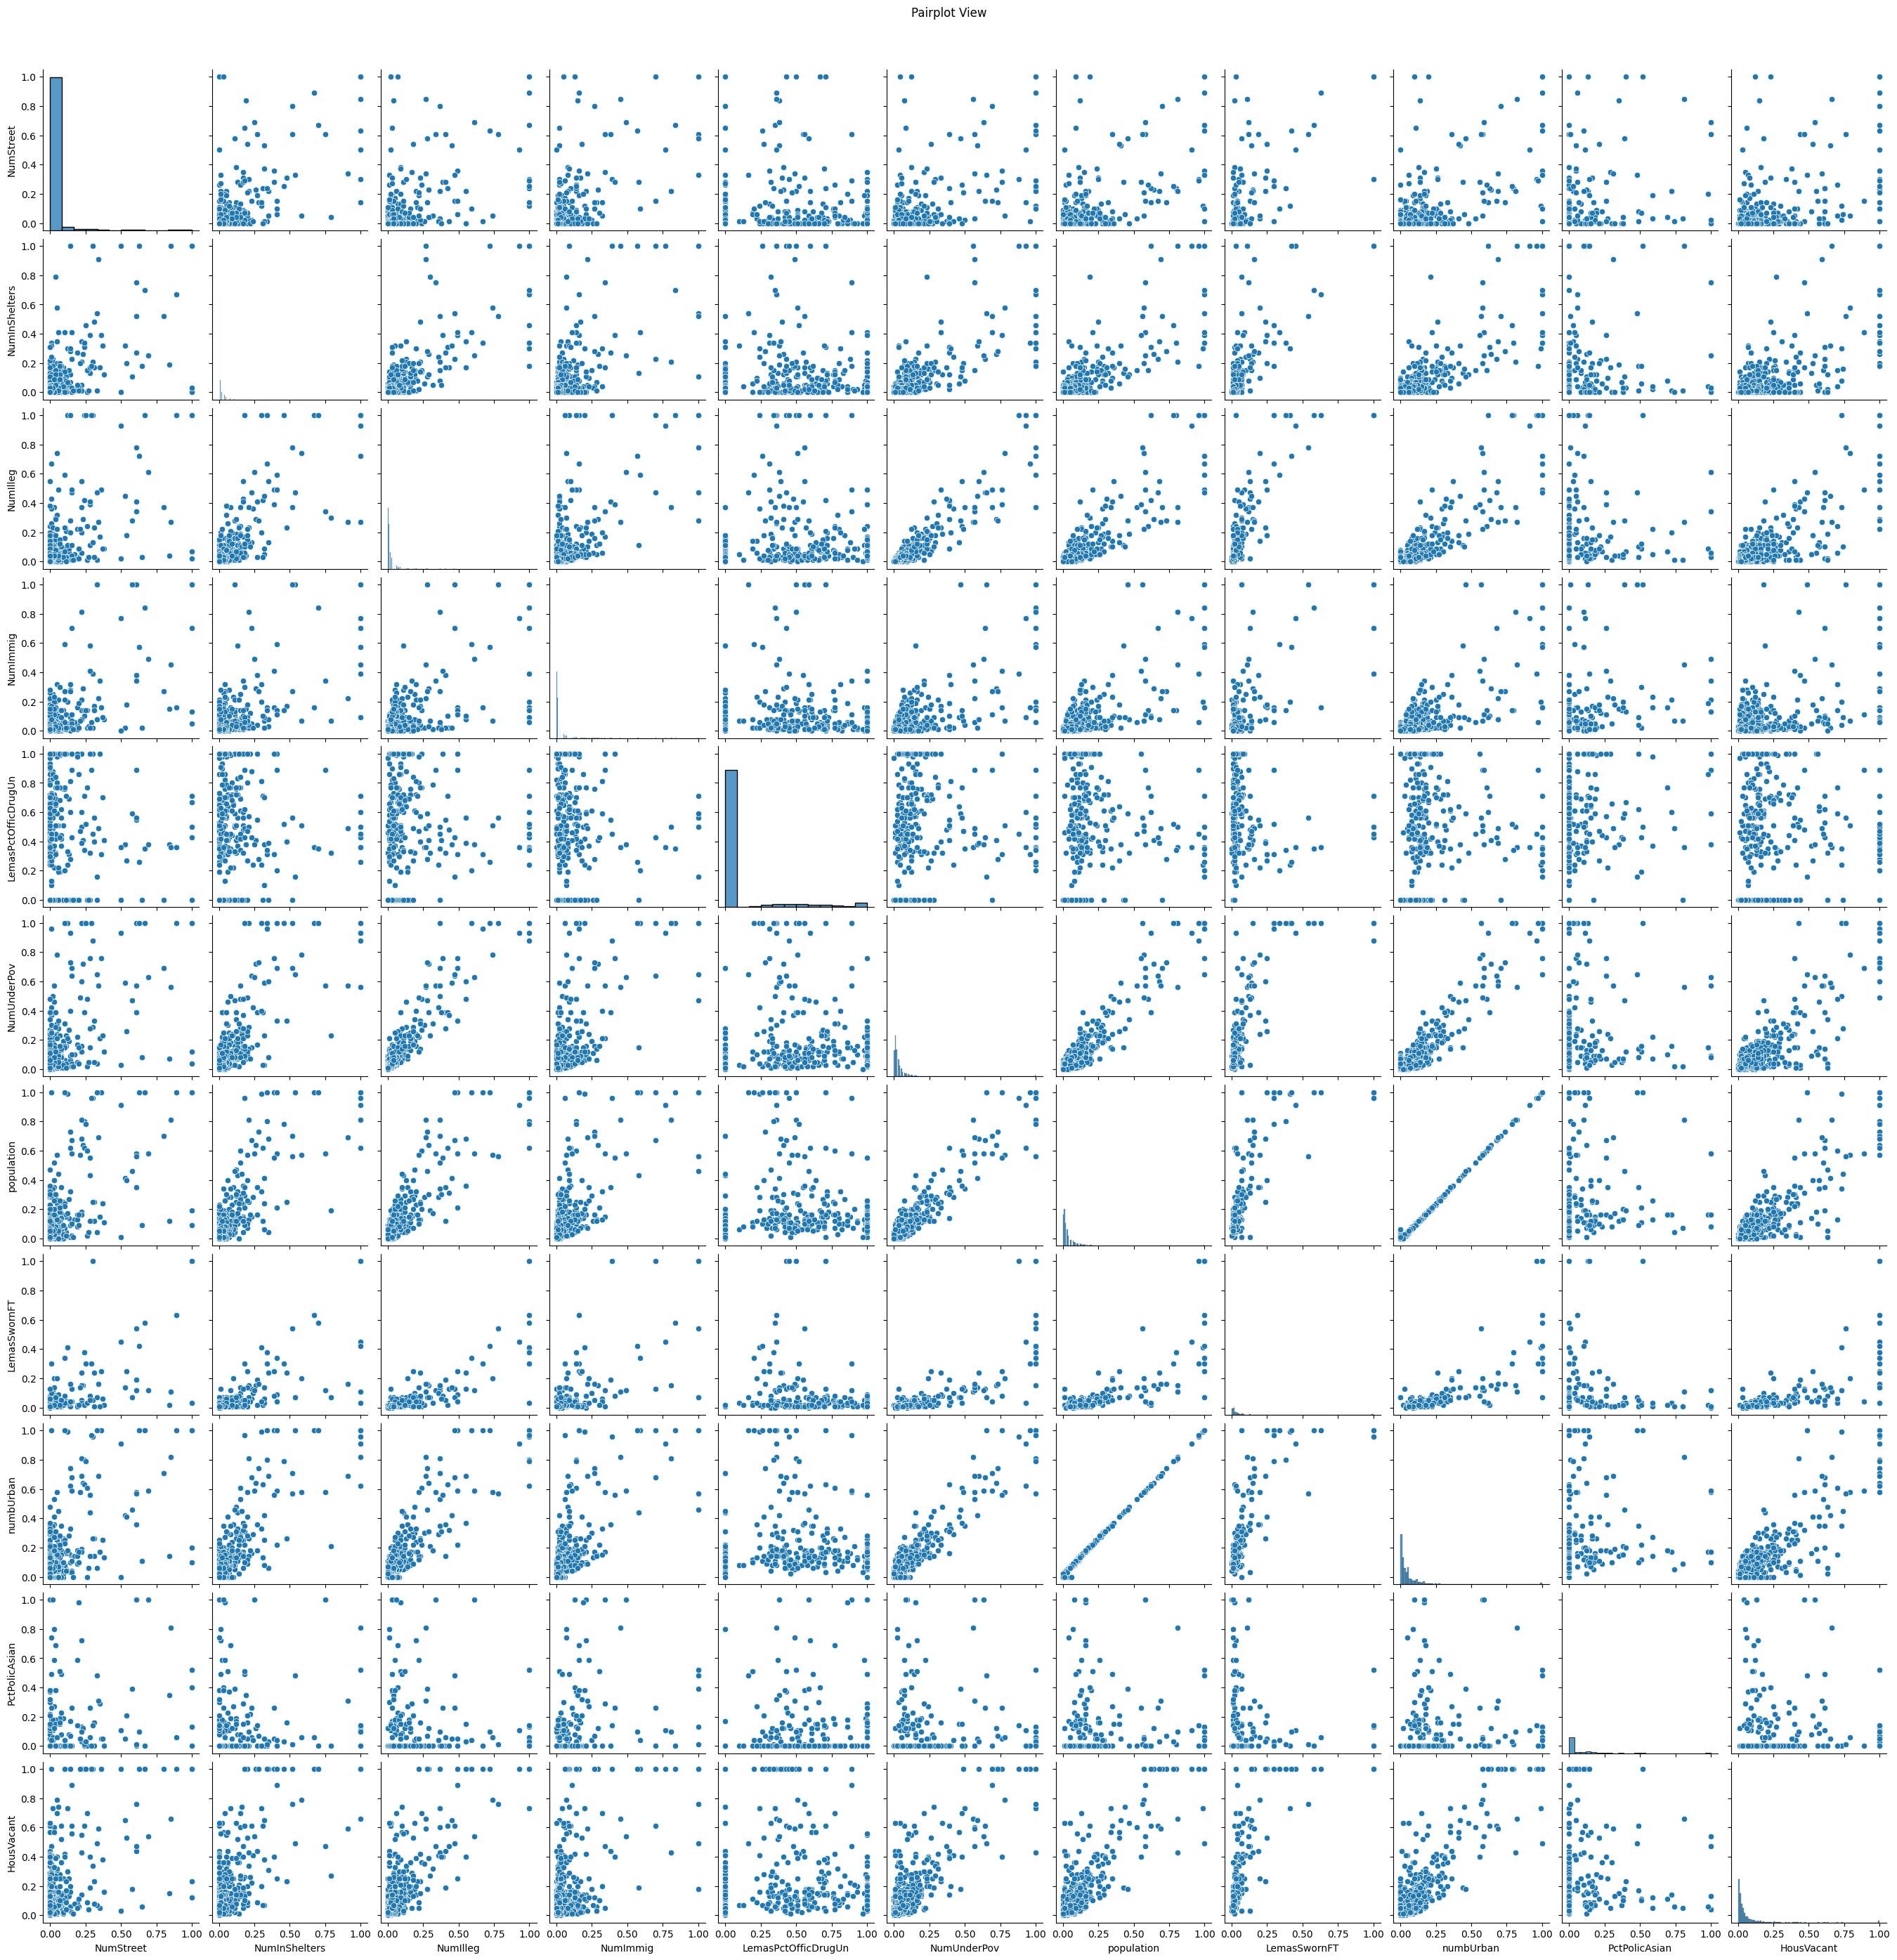

In [103]:
#sqrt (128) = 11.31, so we can take top 11 features
top_cv_features = cv_series.head(11)
top_features = top_cv_features.index.tolist()
cv_features = train_set[top_features]
sns.pairplot(cv_features)
plt.suptitle("Pairplot View", y=1.02)
plt.show()

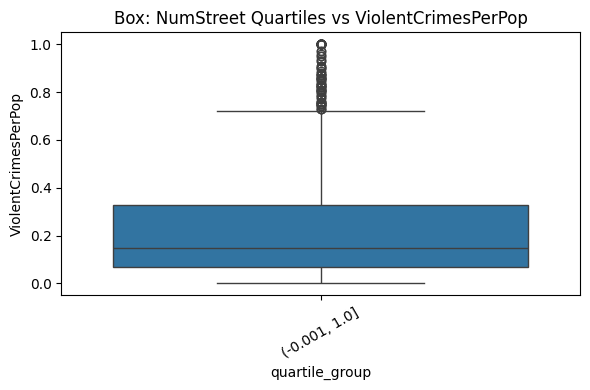

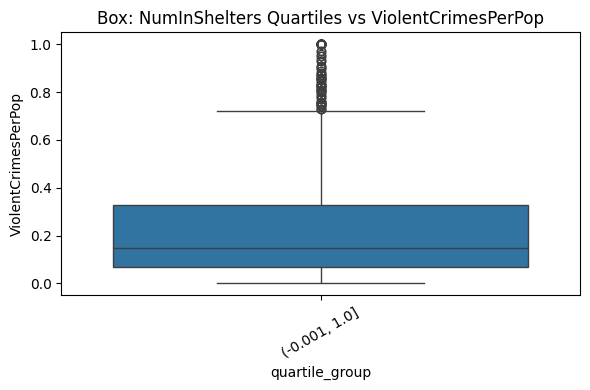

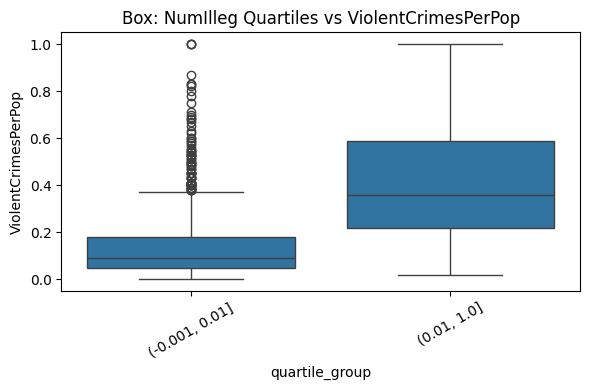

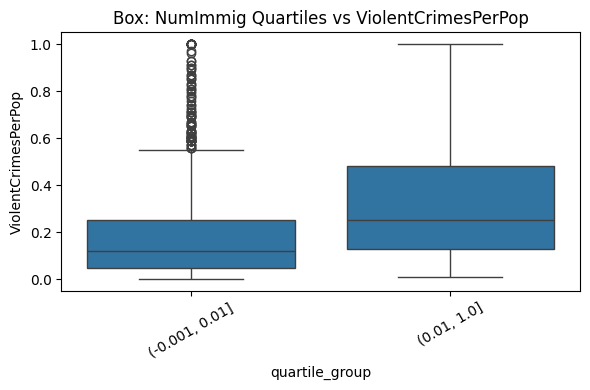

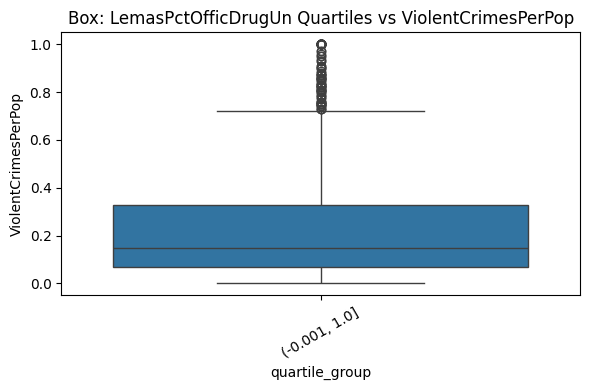

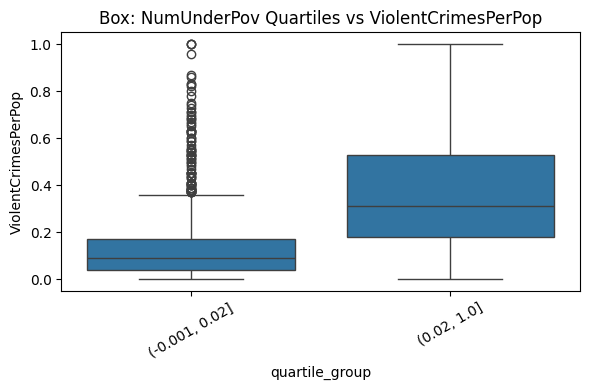

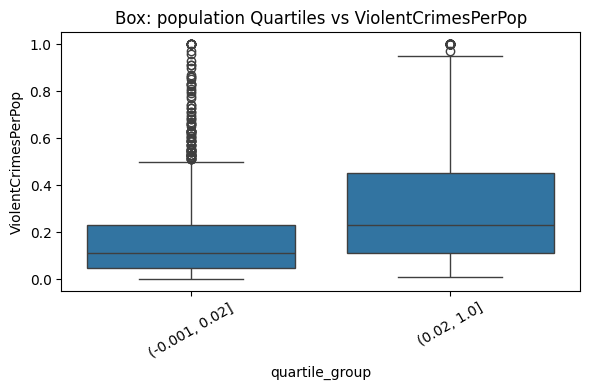

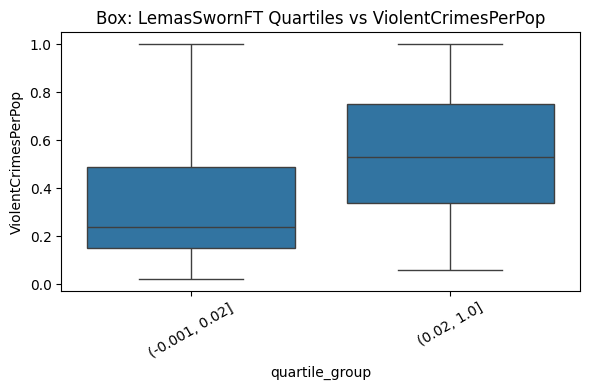

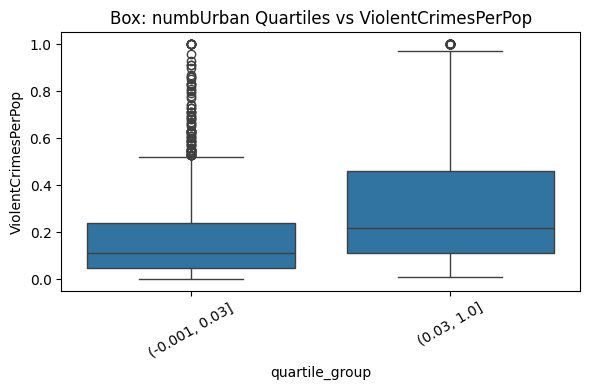

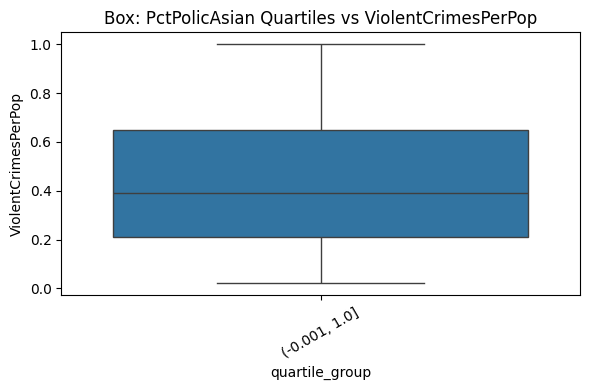

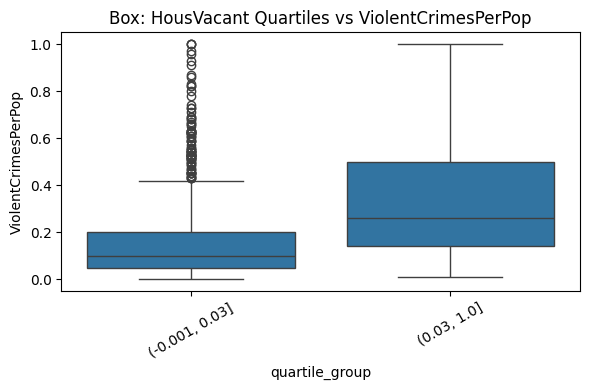

In [104]:
target_col = "ViolentCrimesPerPop"
for feature in top_features:
    df['quartile_group'] = pd.qcut(df[feature], q=2, duplicates='drop')
    
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='quartile_group', y=target_col, data=df)
    plt.title(f"Box: {feature} Quartiles vs {target_col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

We can conclude some information. For example, NumStreet do not have a huge influence on Crimepop; NumIlleg and NumImmig have some relation with the Crimepop. Also, PctPolicAsian might not have much influence.

### f).

In [105]:
X_train = train_set.drop(columns=["ViolentCrimesPerPop"])
y_train = train_set["ViolentCrimesPerPop"]
X_test = test_set.drop(columns=["ViolentCrimesPerPop"])
y_test = test_set["ViolentCrimesPerPop"]

#Fill all teh NaN.
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
print(X_train.describe())
print(np.any(np.isnan(X_train))) 

ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)
mse_ols = mean_squared_error(y_test, y_pred)
print(f"Test MSE : {mse_ols}")
#I am not sure why the MSE is so high, it 

        population  householdsize  racepctblack  racePctWhite  racePctAsian  \
count  1495.000000    1495.000000   1495.000000   1495.000000   1495.000000   
mean      0.058167       0.461732      0.179839      0.752829      0.153712   
std       0.130359       0.164284      0.256970      0.248594      0.208910   
min       0.000000       0.000000      0.000000      0.000000      0.000000   
25%       0.010000       0.350000      0.020000      0.640000      0.040000   
50%       0.020000       0.430000      0.060000      0.850000      0.070000   
75%       0.050000       0.540000      0.220000      0.940000      0.170000   
max       1.000000       1.000000      1.000000      1.000000      1.000000   

       racePctHisp  agePct12t21  agePct12t29  agePct16t24   agePct65up  ...  \
count  1495.000000  1495.000000  1495.000000  1495.000000  1495.000000  ...   
mean      0.144963     0.422649     0.492087     0.335425     0.428569  ...   
std       0.233694     0.155993     0.143352     0.

### g).

In [106]:
alphas = np.logspace(-3, 3, 100)
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(X_train, y_train)
print(f"Best alpha : {ridge.alpha_:.4f}")

y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Test MSE : {mse_ridge:.4f}")


Best alpha : 2.1544
Test MSE : 0.0176


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


### h).

In [107]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()
lasso_1 = LassoCV(cv=5, random_state=42)
lasso_1.fit(X_train_1, y_train)
y_pred_1 = lasso_1.predict(X_test_1)
mse_1 = mean_squared_error(y_test, y_pred_1)
selected_features_1 = X_train.columns[np.abs(lasso_1.coef_) > 1e-6]

print("Original Lasso")
print(f"Best lambda : {lasso_1.alpha_:.4f}")
print(f"Test MSE : {mse_1:.4f}")
print(f"Selected features : {list(selected_features_1)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lasso_scaled = LassoCV(cv=5, random_state=42)
lasso_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = lasso_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
selected_features_scaled = X_train.columns[np.abs(lasso_scaled.coef_) > 1e-6]

print("\nStandardized Lasso")
print(f"Best lambda : {lasso_scaled.alpha_:.4f}")
print(f"Test MSE : {mse_scaled:.4f}")
print(f"Selected features : {list(selected_features_scaled)}")

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009752930226166967, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010113610151826435, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(


Original Lasso
Best lambda : 0.0001
Test MSE : 0.0177
Selected features : ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn',

C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009826702370538953, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010211306995714153, tolerance: 0.0067464160785953185
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:683: Co

### i).

In [108]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mse_list = []
components_range = range(1, X_train.shape[1]+1)

for m in components_range:
    pca = PCA(n_components=m)
    X_pca = pca.fit_transform(X_train_scaled)
    model = LinearRegression()
    scores = cross_val_score(model, X_pca, y_train, cv=5, scoring='neg_mean_squared_error')
    mse = -np.mean(scores)
    mse_list.append(mse)

optimal_m = np.argmin(mse_list) + 1
print(f"Optimal M: {optimal_m}")

pca = PCA(n_components=optimal_m)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
model_pcr = LinearRegression()
model_pcr.fit(X_train_pca, y_train)
y_pred_pcr = model_pcr.predict(X_test_pca)

mse_pcr = mean_squared_error(y_test, y_pred_pcr)
print(f"Test MSE: {mse_pcr:.4f}")

Optimal M: 95
Test MSE: 0.0183


### j).

In [109]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'alpha': np.logspace(-3, 1, 10)
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print(f"Best α from CV: {grid_search.best_params_['alpha']}")
print(f"Test MSE: {mse_xgb:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best α from CV: 3.593813663804626
Test MSE: 0.0180
